In [1]:
import pandas as pd
import seaborn as sns

In [2]:
import sys
sys.path.append("..")

In [3]:
from src import disjoint_cv

In [4]:
label_df =pd.read_csv('../data/input/labeled_ddi_DBv5.0.3.csv')

In [5]:
ddi5_df = pd.read_csv('../data/input/ddi_v5.txt', sep='\t')

In [6]:
ddi4_df = pd.read_csv('../data/input/ddi_v4.txt', sep='\t')

In [7]:
ddi4_df.head()

,Drug1,Drug2
0,DB00005,DB00026
1,DB00026,DB00005
2,DB00005,DB00065
3,DB00065,DB00005
4,DB00005,DB00072


In [8]:
def swap(drug1, drug2):
    if drug1 < drug2:
        return drug1,drug2
    else:
        return drug2,drug1

In [9]:
def getPositiveLabeledPairs(ddiset_df, label_df):
    pairs = []
    classes = []

    ddiKnown = set(ddiset_df.apply(lambda row: swap(row[0],row[1]), axis=1))
    ddiLabel = set(label_df.apply(lambda row: swap(row[0],row[1]), axis=1))
    
    all_positives = ddiKnown.intersection(ddiLabel)
    commonDrugs = set([ d1 for (d1,d2) in all_positives])
    print("Postive size: %d" % len(all_positives))
    print ('Drugs',len(commonDrugs))
    return commonDrugs, all_positives

In [10]:
common_drugs_db5, all_positives_db5 =getPositiveLabeledPairs(ddi5_df, label_df)

Postive size: 175866
Drugs 1528


In [52]:
from scipy.stats import chisquare

def classify_4labels(a):
    if a in [49, 47,73]:
        return a
    else:
        return 0

def chisquare_prediction(obs, exp):
    a= obs.apply(classify_4labels).value_counts()
    b= exp.apply(classify_4labels).value_counts()
    a.name = 'obs'
    b.name = 'exp'
    frequency_dist = pd.concat([a, b], axis=1).dropna()
    frequency_dist.exp = 100 *frequency_dist.exp/float(sum(frequency_dist.exp)) 
    frequency_dist.obs = 100 *frequency_dist.obs/float(sum(frequency_dist.obs)) 
    #frequency_dist = frequency_dist[frequency_dist > 4].dropna()
    #print (frequency_dist.head())
    #print ('Sum', sum(frequency_dist.obs), sum(frequency_dist.exp))
    return chisquare(f_obs= frequency_dist.obs,   # Array of observed counts
                f_exp= frequency_dist.exp)

In [60]:
def plot_distribution_k_fold(commonDrugs, all_positives, n_fold):
    #train_drugs, test_drugs, train_positives, test_positives_drugwise, test_positives_pairwise  = disjoint_cv.drugwise_k_fold_cross(commonDrugs, all_positives, n_fold)
        #c1_results = pd.DataFrame()
    
    drugwise_results = pd.DataFrame()
    pairwise_results = pd.DataFrame()
    train_results = pd.DataFrame()
    
    distribution = pd.DataFrame()
    
    drug_k_fold = disjoint_cv.drugwise_k_fold_cross(commonDrugs, all_positives, n_fold)
    for i,(fold_data) in enumerate(drug_k_fold):
        #print ('fold',i)
        i, train_drugs, test_drugs, train_positives, test_positives_drugwise, test_positives_pairwise = fold_data
        #print ("train drugs",len(train_drugs),"test drugs",len(test_drugs))
        
        train_positives_df = pd.DataFrame(train_positives, columns=['Drug1','Drug2'])
        train_positives_df = train_positives_df.merge(label_df, how='left', on=['Drug1','Drug2'])
        train_results = train_results.append(train_positives_df, ignore_index=True)
        
        test_drugwise_df = pd.DataFrame(test_positives_drugwise, columns=['Drug1','Drug2'])
        test_drugwise_df = test_drugwise_df.merge(label_df, how='left', on=['Drug1','Drug2'])
        drugwise_results= drugwise_results.append(test_drugwise_df,ignore_index=True)
        
        test_pairwise_df = pd.DataFrame(test_positives_pairwise, columns=['Drug1','Drug2'])
        test_pairwise_df = test_pairwise_df.merge(label_df, how='left', on=['Drug1','Drug2'])
        pairwise_results = pairwise_results.append(test_pairwise_df, ignore_index=True)
        
        chisqure_dw = chisquare_prediction(obs=test_drugwise_df.Label, exp= train_positives_df.Label)
        chisquare_pw = chisquare_prediction(obs=test_pairwise_df.Label, exp= train_positives_df.Label)
        #print ('Drug-wise Test & Train','Pairwise Test & Train')
        #print ('Chisquare-statistic \t p-value  \t Chisquare-statistic  \t p-value' )
        print (chisqure_dw[0],'\t', chisqure_dw[1],'\t', chisquare_pw[0],'\t', chisquare_pw[1] )

        
   
        a = test_drugwise_df.Label.value_counts()
        b = test_pairwise_df.Label.value_counts()
        c = train_positives_df.Label.value_counts()
        a.name = 'Drug-wise test set'
        b.name = 'Pairwise test set'
        c.name = 'Traning set'
        
        frequency_dist = pd.concat([a, b, c], axis=1).fillna(0)
        frequency_dist['fold'] = i
        frequency_dist['label'] = frequency_dist.index

        distribution = distribution.append(frequency_dist, ignore_index=True)
    
    return distribution, train_results, drugwise_results, pairwise_results
    

In [66]:
distribution, train_results, drugwise_results, pairwise_results = plot_distribution_k_fold(common_drugs_db5, all_positives_db5, n_fold=10)

0.9022951396533586 	 0.8248739039296964 	 1.9353384165936043 	 0.5859353185635261
0.6430468554481726 	 0.8865108616549571 	 1.9831432526326016 	 0.5759127471276964
1.5904127734727191 	 0.6615656076267147 	 3.577254746738418 	 0.3108797972844489
1.0105157862053347 	 0.7987074678195553 	 3.168699005417955 	 0.36633929428895073
0.27655907225311416 	 0.964375063318296 	 1.8538076241213288 	 0.6032963708317152
2.164643355474235 	 0.5389460603385456 	 7.255765379473601 	 0.06417738537358676
0.20995860204532976 	 0.975965850632633 	 1.0105036061256734 	 0.7987104149614397
0.28439025242593224 	 0.9629370113803117 	 1.0338407667494105 	 0.7930642504797326
1.6774226324041073 	 0.6419648712125634 	 5.8191607752624215 	 0.12074768697576785
0.8482870854474595 	 0.8378858908660801 	 3.0075633963982114 	 0.3904605186812064


/opt/conda/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/opt/conda/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


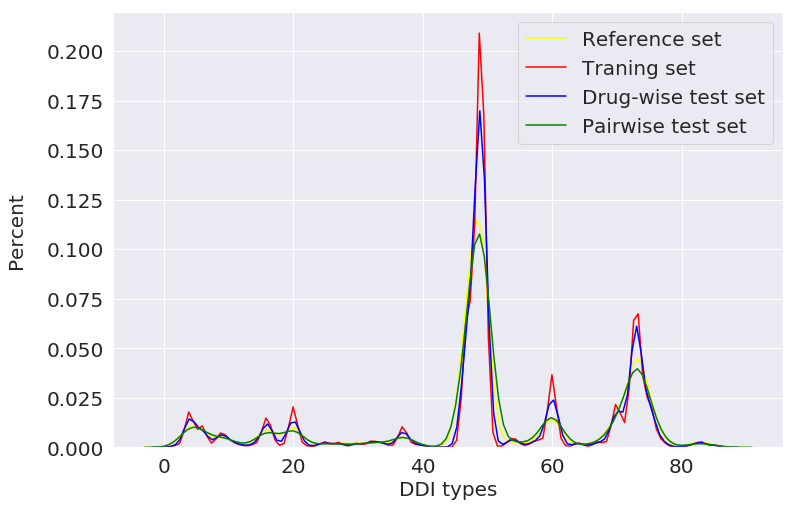

In [55]:

sns.set(rc={'figure.figsize':(12,8),'legend.fontsize': 20.0})
ax = sns.distplot( label_df.Label ,hist =False, norm_hist= True, color="yellow", label="Reference set")    
ax = sns.distplot( train_results.Label ,hist =False, norm_hist= True, color="red", label="Traning set")    
ax = sns.distplot( drugwise_results.Label, hist =False,norm_hist= True, color="blue", label="Drug-wise test set")
ax = sns.distplot( pairwise_results.Label, hist =False,norm_hist= True, color="green", label="Pairwise test set")

ax.set_ylabel("Percent",fontsize=20)
ax.set_xlabel("DDI types",fontsize=20)
ax.yaxis.labelpad = 20
ax.tick_params(labelsize=20)
ax.figure.savefig("db5_percent_test_mean_distribution.png")

In [67]:
distribution.head()

,Drug-wise test set,Pairwise test set,Traning set,fold,label
0,0.0,0.0,1.0,9,1.0
1,21.0,0.0,113.0,9,2.0
2,4.0,0.0,28.0,9,3.0
3,778.0,55.0,1926.0,9,4.0
4,8.0,0.0,181.0,9,5.0


In [68]:
dist = distribution.pivot(index='label', columns='fold', values=['Traning set', 'Drug-wise test set', 'Pairwise test set']) 

In [69]:
dist.to_csv('../results/db5_distribution_train_test.csv')

In [70]:
common_drugs_db4, all_positives_db4 =getPositiveLabeledPairs(ddi4_df, label_df)

Postive size: 34583
Drugs 1098


In [71]:
ddi4_labels = pd.DataFrame(all_positives_db4, columns=['Drug1','Drug2'])

In [72]:
ddi4_labels = ddi4_labels.merge(label_df, how='left', on=['Drug1','Drug2'])

In [73]:
distribution, train_results, drugwise_results, pairwise_results = plot_distribution_k_fold(common_drugs_db4, all_positives_db4, n_fold=10)

2.743147941659627 	 0.4329444834014622 	 6.803532178065405 	 0.07843061957603452
1.1443684421283402 	 0.7663755790197897 	 4.3695815290323985 	 0.22422251385086445
1.119368109191651 	 0.7724007219366603 	 5.595430429430236 	 0.13304093853835589
1.3566880404201187 	 0.7157179439205172 	 5.126766292827815 	 0.1627465787896467
0.5271493495149231 	 0.9128875915020997 	 1.147649260953957 	 0.7655855672408981
0.2868816631226007 	 0.9624765043582809 	 0.4583021630622677 	 0.9279519550409204
0.7393284451307521 	 0.863916793178613 	 0.9013105801230779 	 0.8251115243921153
1.0653273290194862 	 0.7854500990469221 	 11.164508503669898 	 0.010868776808294177
0.6374492641964209 	 0.8878082101039867 	 2.98771988335206 	 0.3935224064395729
0.9892532617951748 	 0.8038523277685449 	 4.479680156691303 	 0.21410994805585637


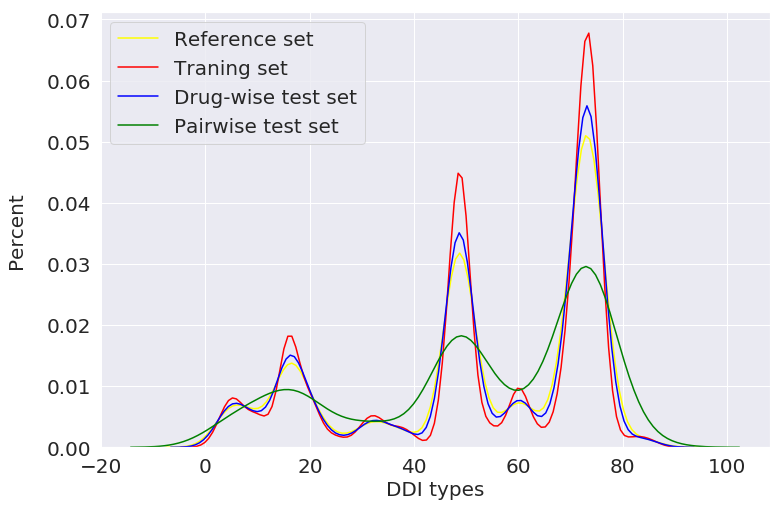

In [19]:
sns.set(rc={'figure.figsize':(12,8),'legend.fontsize': 20.0})
ax = sns.distplot( ddi4_labels.Label ,hist =False, norm_hist= True, color="yellow", label="Reference set")    
ax = sns.distplot( train_results.Label ,hist =False, norm_hist= True, color="red", label="Traning set")    
ax = sns.distplot( drugwise_results.Label, hist =False,norm_hist= True, color="blue", label="Drug-wise test set")
ax = sns.distplot( pairwise_results.Label, hist =False,norm_hist= True, color="green", label="Pairwise test set")

ax.set_ylabel("Percent",fontsize=20)
ax.set_xlabel("DDI types",fontsize=20)
ax.yaxis.labelpad = 20
ax.tick_params(labelsize=20)
ax.figure.savefig("db4_percent_test_mean_distribution.png")

In [74]:
dist = distribution.pivot(index='label', columns='fold', values=['Traning set', 'Drug-wise test set', 'Pairwise test set']) 

In [75]:
dist.to_csv('../results/db4_distribution_train_test.csv')